# CAV 2020 Artifact

- paper: **Learning Task Specifications from Demonstrations via the Principle of Maximum Causal Entropy**
- authors: Marcell Vazquez-Chanlatte, Sanjit A. Seshia


This notebook is designed to be run sequentially; however the majority of the notebook is setup for the final section on actually performing inference. As such, we have provided the following TOC to get an overview of the notebook.

## TOC:
1. [Dynamical System](#1.-Create-Dynamical-System)
2. [Sensor and Visualizing the Map](#2.-Create-Sensor-+-Visualize-Map)
3. [Demonstrations](#3.-Describe-demonstrations)
4. [Concept Class](#4.-Define-Specification-Circuits)
5. [Specification Inference](#5.-Run-Maximum-Casual-Entropy-Specification-Inference)

In [1]:
import aiger as A
import aiger_bv as BV
import aiger_coins as C
import aiger_gridworld as GW
import aiger_ptltl as LTL
import funcy as fn
import matplotlib.pyplot as plt
import seaborn as sns
from bidict import bidict

# 1. Create Dynamical System

Here we create a BitVector sequential circuit, `DYN`, using `py-aiger`, the models a gridworld (line 4).

Afterwords, lines 6-8 describe introducing a slip probability of `1/32` (modeled by a biased coin with bias `31/32`). 

**Note that states are 1-hot encoded**

In [2]:
X = BV.atom(8, 'x', signed=False)
Y = BV.atom(8, 'y', signed=False)

DYN = GW.gridworld(8, start=(3, 5), compressed_inputs=True)

SLIP = BV.atom(1, 'c', signed=False).repeat(2) & BV.atom(2, 'a', signed=False)
SLIP = SLIP.with_output('a').aigbv
DYN2 = C.coin((31, 32), 'c') >> C.circ2mdp(DYN << SLIP)

def encode_state(x, y):
    x, y = [BV.encode_int(8, 1 << (v - 1), signed=False) for v in (x, y)]
    return {'x': tuple(x), 'y': tuple(y)}

In [3]:
encode_state(2, 3)

{'x': (False, True, False, False, False, False, False, False),
 'y': (False, False, True, False, False, False, False, False)}

# 2. Create Sensor / Feature overlay

Next, we define the mapping from concrete states to sensor values / atomic predicates.
We use simple coordinate wise bitvector masks to encode the color overlays.

In [4]:
def mask_test(xmask, ymask):
    return ((X & xmask) !=0) & ((Y & ymask) != 0)


APS = {       #            x-axis       y-axis
    'yellow': mask_test(0b1000_0001, 0b1000_0001),
    'blue':   mask_test(0b0001_1000, 0b0011100),
    'brown':   mask_test(0b0011_1100, 0b1000_0001),
    'red':    mask_test(0b1000_0001, 0b0100_1100) \
            | mask_test(0b0100_0010, 0b1100_1100),
}

def create_sensor(aps):
    sensor = BV.aig2aigbv(A.empty())
    for name, ap in APS.items():
        sensor |= ap.with_output(name).aigbv
    return sensor


SENSOR = create_sensor(APS)

## Visualizing Overlay

This can all seem pretty abstract, so let's visualize the way the sensor sees the board.

In [5]:
from IPython.display import HTML as html_print


COLOR_ALIAS = {
    'yellow': '#ffff8c', 'brown': '#ffb081',
    'red': '#ff5454', 'blue': '#9595ff'
}


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, in_ascii=False):
    """Use sensor to create colored tile."""
    state = encode_state(x, y)
    obs = SENSOR(state)[0]   # <----------   

    for k in COLOR_ALIAS.keys():
        if obs[k][0]:
            return tile(k)
    return tile('white')

def print_map():
    """Scan the board row by row and print colored tiles."""
    order = range(1, 9)
    for y in order:
        chars = (ap_at_state(x, y, in_ascii=True) for x in order)
        display(html_print('&nbsp;'.join(chars)))
        
print_map()

# 3. Describe demonstrations

We now encode a collection of demonstrations from an agent attempting to:

1. Avoid the red tiles (lava).
2. Reach the yellow tiles (recharge).
3. If the agent touches a blue tile (water), then it must dry off (brown tile) before recharging.

**Note** Trace 5 corresponds to a very unlikely demonstration where the agent enters the water, but is unable to dry off due to wind.

In [6]:
ACTION2ARROW = bidict({
    GW.NORTH_C: '↑',
    GW.SOUTH_C: '↓',
    GW.WEST_C: '←',
    GW.EAST_C: '→',
})


def print_trc(trc, idx=0):
    actions, states = trc
    obs = (ap_at_state(*pos, in_ascii=True) for pos in states)
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(actions, obs)) + '\n')
    )

ACTIONS0 = "→→↑↑↑↑→→→"
STATES0 = ((4, 5), (5, 5), (5, 4), (5, 3),(5, 2), (5, 1), (6, 1), (7, 1), (8, 1))
TRC0 = (ACTIONS0, STATES0)
print_trc(TRC0, 0)

ACTIONS1 = "↑↑↑↑←←←←←"
STATES1 = ((3, 4), (3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1),)
TRC1 = (ACTIONS1, STATES1)
print_trc(TRC1, 1)

ACTIONS2 = "←→↑↑↑←↑←←"
STATES2 = ((2, 5), (3, 5), (3, 4), (3, 3), (3, 2), (2, 2), (2, 1), (1, 1), (1, 1))
TRC2 = (ACTIONS2, STATES2)
print_trc(TRC2, 2)

ACTIONS3 = "↑↑→←↑↑←←←"
STATES3 = ((3, 4), (3, 3), (4, 3), (3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 1))
TRC3 = (ACTIONS3, STATES3)
print_trc(TRC3, 3)

ACTIONS4 = "↑→↑↑↑←←←←"
STATES4 = ((3, 4), (4, 4), (4, 3), (4, 2), (4, 1), (3, 1), (2, 1), (1, 1), (1, 1))
TRC4 = (ACTIONS4, STATES4)
print_trc(TRC4, 4)

ACTIONS5 = "↑→↑↑←←←↑↑"
STATES5 = ((3, 4), (4, 4), (4, 3), (4, 2), (3, 2), (2, 2), (1, 2), (1, 1), (1, 1))
TRC5 = (ACTIONS5, STATES5)
print_trc(TRC5, 5)

TRACES = [TRC0, TRC1, TRC2, TRC3, TRC4]        # Variety of positive demos.
TRACES += [TRC5]                               # Unlucky, Negative Demonstration.
TRACES = 4 * [TRC4]                            # Additional "Safe" Demonstrations.

## Convert "human readable" demos to bitvectors.

In [7]:
def str2actions(vals):
    return [ACTION2ARROW.inv[c] for c in vals]

def encode_trace(trc):
    actions, states = trc
    actions = str2actions(actions)
    actions = [{'a': a} for a in actions]
    states = [encode_state(*s) for s in states]
    return actions, states

DEMOS = [encode_trace(trc) for trc in TRACES]

# 4. Define Specification Circuits

First, we describe the properties over colors of the map. This is done in past tense temporal logic using `py-aiger-ptltl`.

In [8]:
LAVA, RECHARGE, WATER, DRY = map(LTL.atom, ['red', 'yellow', 'blue', 'brown'])

EVENTUALLY_RECHARGE = RECHARGE.once()
AVOID_LAVA = (~LAVA).historically()

RECHARGED_AND_ONCE_WET = RECHARGE & WATER.once()
DRIED_OFF = (~WATER).since(DRY)

DIDNT_RECHARGE_WHILE_WET = (RECHARGED_AND_ONCE_WET).implies(DRIED_OFF)
DONT_RECHARGE_WHILE_WET = DIDNT_RECHARGE_WHILE_WET.historically()

CONST_TRUE = LTL.atom(True)


SPECS = [
    CONST_TRUE, AVOID_LAVA, EVENTUALLY_RECHARGE, DONT_RECHARGE_WHILE_WET,
    AVOID_LAVA & EVENTUALLY_RECHARGE & DONT_RECHARGE_WHILE_WET,
    AVOID_LAVA & EVENTUALLY_RECHARGE,
    AVOID_LAVA & DONT_RECHARGE_WHILE_WET,
    EVENTUALLY_RECHARGE & DONT_RECHARGE_WHILE_WET,
]

SPEC_NAMES = [
    "CONST_TRUE", "AVOID_LAVA", "EVENTUALLY_RECHARGE", "DONT_RECHARGE_WHILE_WET",
    "AVOID_LAVA & EVENTUALLY_RECHARGE & DONT_RECHARGE_WHILE_WET",
    "AVOID_LAVA & EVENTUALLY_RECHARGE",
    "AVOID_LAVA & DONT_RECHARGE_WHILE_WET",
    "EVENTUALLY_RECHARGE & DONT_RECHARGE_WHILE_WET",
]

## Convert specifications to monitor circuits

In [9]:
def spec2monitor(spec):
    """Ignore unused colors + convert to a BitVector AIG."""
    monitor = spec.aig | A.sink(['red', 'yellow', 'brown', 'blue'])
    monitor = monitor['o', {spec.output: 'sat'}]
    monitor = BV.aig2aigbv(monitor)
    return SENSOR >> monitor
    
SPEC2MONITORS = { spec: spec2monitor(spec) for spec in SPECS }

# 5. Run Maximum Casual Entropy Specification Inference

Finally, we use our maximum causal entropy inference algorithm which computes a BDD representation of the composition of each spec and MDP circuit.

**Note:** Several performance bugs were fixed between this version and the submitted version, resulting in improved BDD construction times.

Package `mce-spec-inference` package available here: https://pypi.org/project/mce-spec-inference/

In [10]:
from mce.infer import spec_mle

best, spec2score = spec_mle(
    DYN2, DEMOS, SPEC2MONITORS.values(), parallel=True
)

encoding traces
done encoding traces
concretizing spec
concretizing spec
concretizing spec
concretizing spec
done spec
fitting policy
done fitting
compute log likelihood of demos

----------------------------

BDD size: 1
Controller Size: 0
log_prob: -174.67308950110655
build spec: 1.2s
fit: 0.003s
surprise: 0.0068s

----------------------------

{'build spec': 1.1604554653167725, 'fit': 0.0029630661010742188, 'surprise': 0.0068323612213134766}
concretizing spec
done spec
fitting policy
done spec
fitting policy
done spec
fitting policy
done fitting
compute log likelihood of demos

----------------------------

BDD size: 1628
Controller Size: 328
log_prob: -158.99448693889673
build spec: 1.3s
fit: 0.85s
surprise: 0.01s

----------------------------

{'build spec': 1.3297436237335205, 'fit': 0.8536343574523926, 'surprise': 0.0104217529296875}
concretizing spec
done fitting
compute log likelihood of demos

----------------------------

BDD size: 850
Controller Size: 195
log_prob: -196.091

## Plotting Results

**Remark**: Based on the reviews, we have slightly changed how we present our likelihood results. Namely:

1. Because of the sheer number of possible traces, the log likelihoods are typically **very** small.
2. As a base line, we compare against the likelihood of generating the demonstrations under uniformly random actions.
3. **Note** that this is equivilent to the likelihood of the demos under the `CONST_TRUE` specification.



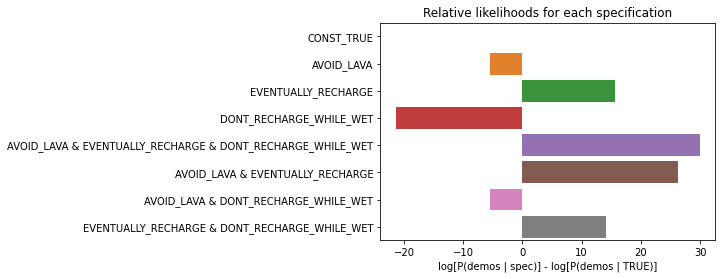

In [11]:
def normalize(score):
    return score - spec2score[SPEC2MONITORS[CONST_TRUE]]

normalized_scores = fn.lmap(normalize, spec2score.values())

sns.barplot(y=SPEC_NAMES, x =normalized_scores, orient='h')
plt.title('Relative likelihoods for each specification')
plt.xlabel('log[P(demos | spec)] - log[P(demos | TRUE)]')
plt.show()

**Note** Final version will use latex in plotting, but for ease of reproduction we stick with ascii

Hopefully, you can see that the most likely demonstration is the intended one, namely,


1. Avoid the red tiles (lava).
2. Reach the yellow tiles (recharge).
3. If the agent touches a blue tile (water), then it must dry off (brown tile) before recharging.

This is despite there being an unlabeled negative demonstration (TRC5) which fails to recharge.